In [1]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [8]:
!git clone https://github.com/SakuraRiven/EAST.git

Cloning into 'EAST'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 78 (delta 33), reused 29 (delta 29), pack-reused 38
Receiving objects: 100% (78/78), 131.72 KiB | 2.23 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [2]:
!pip install -q lanms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.4/973.4 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
%cd EAST

/content/drive/MyDrive/EAST


In [5]:
!CUDA_VISIBLE_DEVICES=0 python eval.py

Calculated!{"precision": 0.8425787106446777, "recall": 0.8117477130476649, "hmean": 0.8268759195684159, "AP": 0}
eval time is 92.04016494750977


#EAST

##MODEL

In [1]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
import math

###Feature Extractor Stem

In [6]:
cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']


def make_layers(cfg, batch_norm=False):
	layers = []
	in_channels = 3
	for v in cfg:
		if v == 'M':
			layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
		else:
			conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
			if batch_norm:
				layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
			else:
				layers += [conv2d, nn.ReLU(inplace=True)]
			in_channels = v
	return nn.Sequential(*layers)

VGG Class

In [3]:
class VGG(nn.Module):
	def __init__(self, features):
		super(VGG, self).__init__()
		self.features = features
		self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
		self.classifier = nn.Sequential(
			nn.Linear(512 * 7 * 7, 4096),
			nn.ReLU(True),
			nn.Dropout(),
			nn.Linear(4096, 4096),
			nn.ReLU(True),
			nn.Dropout(),
			nn.Linear(4096, 1000),
		)

		for m in self.modules():
			if isinstance(m, nn.Conv2d):
				nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
				if m.bias is not None:
					nn.init.constant_(m.bias, 0)
			elif isinstance(m, nn.BatchNorm2d):
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 0)
			elif isinstance(m, nn.Linear):
				nn.init.normal_(m.weight, 0, 0.01)
				nn.init.constant_(m.bias, 0)

	def forward(self, x):
		x = self.features(x)
		x = self.avgpool(x)
		x = x.view(x.size(0), -1)
		x = self.classifier(x)
		return x

Feature Extractor

In [11]:
vgg_path = '/content/drive/MyDrive/EAST/pths/vgg16_bn-6c64b313.pth'

In [12]:
class extractor(nn.Module):
	def __init__(self, pretrained):
		super(extractor, self).__init__()
		vgg16_bn = VGG(make_layers(cfg, batch_norm=True))
		if pretrained:
			vgg16_bn.load_state_dict(torch.load(vgg_path))
		self.features = vgg16_bn.features

	def forward(self, x):
		out = []
		for m in self.features:
			x = m(x)
			if isinstance(m, nn.MaxPool2d):
				out.append(x)
		return out[1:]

###Feature Merging Branch

In [5]:
class merge(nn.Module):
	def __init__(self):
		super(merge, self).__init__()

		self.conv1 = nn.Conv2d(1024, 128, 1)
		self.bn1 = nn.BatchNorm2d(128)
		self.relu1 = nn.ReLU()
		self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
		self.bn2 = nn.BatchNorm2d(128)
		self.relu2 = nn.ReLU()

		self.conv3 = nn.Conv2d(384, 64, 1)
		self.bn3 = nn.BatchNorm2d(64)
		self.relu3 = nn.ReLU()
		self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
		self.bn4 = nn.BatchNorm2d(64)
		self.relu4 = nn.ReLU()

		self.conv5 = nn.Conv2d(192, 32, 1)
		self.bn5 = nn.BatchNorm2d(32)
		self.relu5 = nn.ReLU()
		self.conv6 = nn.Conv2d(32, 32, 3, padding=1)
		self.bn6 = nn.BatchNorm2d(32)
		self.relu6 = nn.ReLU()

		self.conv7 = nn.Conv2d(32, 32, 3, padding=1)
		self.bn7 = nn.BatchNorm2d(32)
		self.relu7 = nn.ReLU()

		for m in self.modules():
			if isinstance(m, nn.Conv2d):
				nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
				if m.bias is not None:
					nn.init.constant_(m.bias, 0)
			elif isinstance(m, nn.BatchNorm2d):
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 0)

	def forward(self, x):
		y = F.interpolate(x[3], scale_factor=2, mode='bilinear', align_corners=True)
		y = torch.cat((y, x[2]), 1)
		y = self.relu1(self.bn1(self.conv1(y)))
		y = self.relu2(self.bn2(self.conv2(y)))

		y = F.interpolate(y, scale_factor=2, mode='bilinear', align_corners=True)
		y = torch.cat((y, x[1]), 1)
		y = self.relu3(self.bn3(self.conv3(y)))
		y = self.relu4(self.bn4(self.conv4(y)))

		y = F.interpolate(y, scale_factor=2, mode='bilinear', align_corners=True)
		y = torch.cat((y, x[0]), 1)
		y = self.relu5(self.bn5(self.conv5(y)))
		y = self.relu6(self.bn6(self.conv6(y)))

		y = self.relu7(self.bn7(self.conv7(y)))
		return y

###Output

In [7]:
class output(nn.Module):
	def __init__(self, scope=512):
		super(output, self).__init__()
		self.conv1 = nn.Conv2d(32, 1, 1)
		self.sigmoid1 = nn.Sigmoid()
		self.conv2 = nn.Conv2d(32, 4, 1)
		self.sigmoid2 = nn.Sigmoid()
		self.conv3 = nn.Conv2d(32, 1, 1)
		self.sigmoid3 = nn.Sigmoid()
		self.scope = 512
		for m in self.modules():
			if isinstance(m, nn.Conv2d):
				nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
				if m.bias is not None:
					nn.init.constant_(m.bias, 0)

	def forward(self, x):
		score = self.sigmoid1(self.conv1(x))
		loc   = self.sigmoid2(self.conv2(x)) * self.scope
		angle = (self.sigmoid3(self.conv3(x)) - 0.5) * math.pi
		geo   = torch.cat((loc, angle), 1)
		return score, geo

###EAST

In [8]:
class EAST(nn.Module):
	def __init__(self, pretrained=True):
		super(EAST, self).__init__()
		self.extractor = extractor(pretrained)
		self.merge     = merge()
		self.output    = output()

	def forward(self, x):
		return self.output(self.merge(self.extractor(x)))


In [13]:
m = EAST()
x = torch.randn(1, 3, 256, 256)
score, geo = m(x)
print(score.shape)
print(geo.shape)

torch.Size([1, 1, 64, 64])
torch.Size([1, 5, 64, 64])


#Dataset

In [30]:
import torch
import os
from torchvision import transforms
from PIL import Image, ImageDraw
import numpy as np
!pip install -q lanms
import lanms

In [29]:
def get_rotate_mat(theta):
	'''positive theta value means rotate clockwise'''
	return np.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])

In [24]:
def resize_img(img):
	'''resize image to be divisible by 32
	'''
	w, h = img.size
	resize_w = w
	resize_h = h

	resize_h = resize_h if resize_h % 32 == 0 else int(resize_h / 32) * 32
	resize_w = resize_w if resize_w % 32 == 0 else int(resize_w / 32) * 32
	img = img.resize((resize_w, resize_h), Image.BILINEAR)
	ratio_h = resize_h / h
	ratio_w = resize_w / w

	return img, ratio_h, ratio_w

In [25]:
def load_pil(img):
	'''convert PIL Image to torch.Tensor
	'''
	t = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])
	return t(img).unsqueeze(0)

In [26]:
def is_valid_poly(res, score_shape, scale):
	'''check if the poly in image scope
	Input:
		res        : restored poly in original image
		score_shape: score map shape
		scale      : feature map -> image
	Output:
		True if valid
	'''
	cnt = 0
	for i in range(res.shape[1]):
		if res[0,i] < 0 or res[0,i] >= score_shape[1] * scale or \
           res[1,i] < 0 or res[1,i] >= score_shape[0] * scale:
			cnt += 1
	return True if cnt <= 1 else False

In [31]:
def restore_polys(valid_pos, valid_geo, score_shape, scale=4):
	'''restore polys from feature maps in given positions
	Input:
		valid_pos  : potential text positions <numpy.ndarray, (n,2)>
		valid_geo  : geometry in valid_pos <numpy.ndarray, (5,n)>
		score_shape: shape of score map
		scale      : image / feature map
	Output:
		restored polys <numpy.ndarray, (n,8)>, index
	'''
	polys = []
	index = []
	valid_pos *= scale
	d = valid_geo[:4, :] # 4 x N
	angle = valid_geo[4, :] # N,

	for i in range(valid_pos.shape[0]):
		x = valid_pos[i, 0]
		y = valid_pos[i, 1]
		y_min = y - d[0, i]
		y_max = y + d[1, i]
		x_min = x - d[2, i]
		x_max = x + d[3, i]
		rotate_mat = get_rotate_mat(-angle[i])

		temp_x = np.array([[x_min, x_max, x_max, x_min]]) - x
		temp_y = np.array([[y_min, y_min, y_max, y_max]]) - y
		coordidates = np.concatenate((temp_x, temp_y), axis=0)
		res = np.dot(rotate_mat, coordidates)
		res[0,:] += x
		res[1,:] += y

		if is_valid_poly(res, score_shape, scale):
			index.append(i)
			polys.append([res[0,0], res[1,0], res[0,1], res[1,1], res[0,2], res[1,2],res[0,3], res[1,3]])
	return np.array(polys), index

In [32]:
def get_boxes(score, geo, score_thresh=0.9, nms_thresh=0.2):
	'''get boxes from feature map
	Input:
		score       : score map from model <numpy.ndarray, (1,row,col)>
		geo         : geo map from model <numpy.ndarray, (5,row,col)>
		score_thresh: threshold to segment score map
		nms_thresh  : threshold in nms
	Output:
		boxes       : final polys <numpy.ndarray, (n,9)>
	'''
	score = score[0,:,:]
	xy_text = np.argwhere(score > score_thresh) # n x 2, format is [r, c]
	if xy_text.size == 0:
		return None

	xy_text = xy_text[np.argsort(xy_text[:, 0])]
	valid_pos = xy_text[:, ::-1].copy() # n x 2, [x, y]
	valid_geo = geo[:, xy_text[:, 0], xy_text[:, 1]] # 5 x n
	polys_restored, index = restore_polys(valid_pos, valid_geo, score.shape)
	if polys_restored.size == 0:
		return None

	boxes = np.zeros((polys_restored.shape[0], 9), dtype=np.float32)
	boxes[:, :8] = polys_restored
	boxes[:, 8] = score[xy_text[index, 0], xy_text[index, 1]]
	boxes = lanms.merge_quadrangle_n9(boxes.astype('float32'), nms_thresh)
	return boxes

In [33]:
def adjust_ratio(boxes, ratio_w, ratio_h):
	'''refine boxes
	Input:
		boxes  : detected polys <numpy.ndarray, (n,9)>
		ratio_w: ratio of width
		ratio_h: ratio of height
	Output:
		refined boxes
	'''
	if boxes is None or boxes.size == 0:
		return None
	boxes[:,[0,2,4,6]] /= ratio_w
	boxes[:,[1,3,5,7]] /= ratio_h
	return np.around(boxes)

In [34]:
def detect(img, model, device):
	'''detect text regions of img using model
	Input:
		img   : PIL Image
		model : detection model
		device: gpu if gpu is available
	Output:
		detected polys
	'''
	img, ratio_h, ratio_w = resize_img(img)
	with torch.no_grad():
		score, geo = model(load_pil(img).to(device))
	boxes = get_boxes(score.squeeze(0).cpu().numpy(), geo.squeeze(0).cpu().numpy())
	return adjust_ratio(boxes, ratio_w, ratio_h)

In [35]:
def plot_boxes(img, boxes):
	'''plot boxes on image
	'''
	if boxes is None:
		return img

	draw = ImageDraw.Draw(img)
	for box in boxes:
		draw.polygon([box[0], box[1], box[2], box[3], box[4], box[5], box[6], box[7]], outline=(0,255,0))
	return img

#EVAL

In [17]:
import numpy as np

In [18]:
model_path = '/content/drive/MyDrive/EAST/pths/east_vgg16.pth'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EAST(False).to(device)
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
model.eval()

In [58]:
#img_path = '/content/drive/MyDrive/ICDAR_2015/test_img/img_106.jpg'
img_path = '/content/drive/MyDrive/Medical_ocr/Handwritten_Doctor_Prescriptions_and_Reports/Disha/IMG-20230217-WA0001 - Satwik Tanwar.jpg'

In [59]:
img = Image.open(img_path)
img_og = img
img, ratio_h, ratio_w = resize_img(img)
with torch.no_grad():
  score, geo = model(load_pil(img).to(device))
boxes = get_boxes(score.squeeze(0).cpu().numpy(), geo.squeeze(0).cpu().numpy())
boxes = adjust_ratio(boxes, ratio_w, ratio_h)
plot_img = plot_boxes(img, boxes)

In [49]:
import matplotlib.pyplot as plt

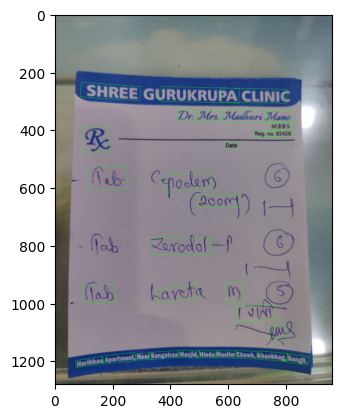

In [60]:
plt.imshow(plot_img)

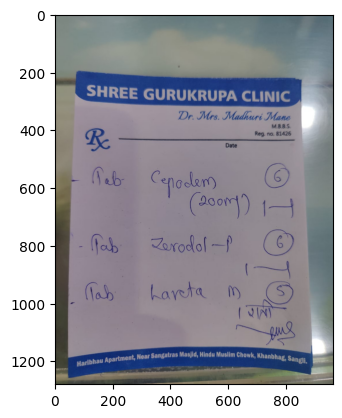

In [61]:
plt.imshow(img_og)